In [1]:
%load_ext autoreload
%autoreload 2

import logging
import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
import torch

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import activation
import cpn_model
import config
import lesion
import loss_funcs
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils

from train import refine_en, train_new_en, train_loop, unroll


logger = logging.getLogger("main")
logger.setLevel(logging.INFO)


OBSERVER_TYPE = observer.ObserverType.gaussian
STIMULATION_TYPE = stim.StimulationType.gaussian_exp
CPN_ACTIVATION_TYPE = activation.ActivationType.Tanh
EN_ACTIVATION_TYPE = activation.ActivationType.Tanh
LESION_TYPE = lesion.LesionType.connection
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CPN_EN_COADAPT = True
CUDA = torch.device(0)

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, \
        run_type_str, run_type_str_short, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


MODEL_OUT_DIR = "models"
LOG_OUT_DIR = "logs"

print("Run config:", run_type_str)
print(run_type_str_short)

Run config: gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2)]_gaussianExp16.2.175_enActTanh_cpnActTanh
obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh


In [2]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)

if CUDA:
    mike.cuda()

mike.set_lesion(lesion_instance)


In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True,
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True,
)

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


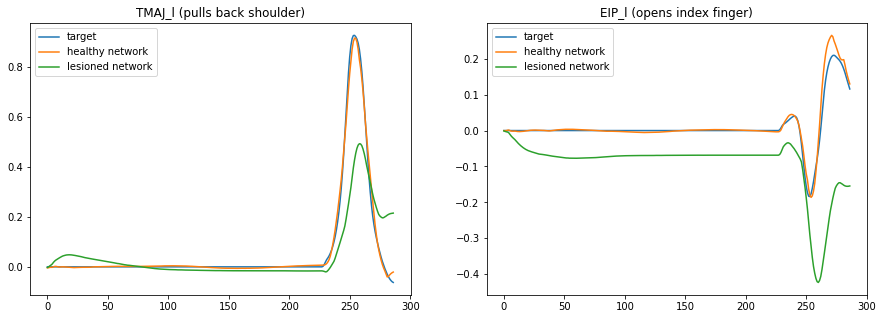

In [4]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].cpu().detach().numpy(), label="target")
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].cpu().detach().numpy(), label="healthy network")
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].cpu().detach().numpy(), label="lesioned network")
ax[0].legend(loc="upper left")
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].cpu().detach().numpy(), label="target")
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].cpu().detach().numpy(), label="healthy network")
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].cpu().detach().numpy(), label="lesioned network")
ax[1].legend(loc="upper left")

plt.show()

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>)


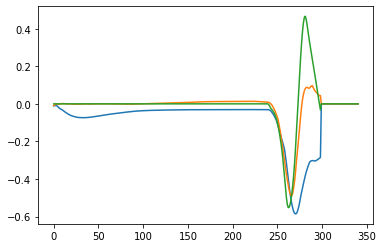

In [5]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_healthy = comp_preds_healthy.cuda(CUDA)
    
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_lesioned = comp_preds_lesioned.cuda(CUDA)
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].cpu().detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].cpu().detach().numpy())
plt.plot(dout[0, :, 20].cpu().detach().numpy())
plt.show()


In [10]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
                             num_neurons=20, activation_func=torch.nn.Tanh,
                             #num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh,
                             cuda=CUDA)

#cpn.load_state_dict(torch.load('min_cpn_F5condrop_obs20_stim16_tightInner))

opt_cpn = AdamW(cpn.parameters(), lr=5e-6)


model_uuid = cpn.uuid
out_postfix = f"{run_type_str_short}_{model_uuid}"

if CPN_EN_COADAPT:
    out_postfix += "_cpnEnCoadapt"
    
model_dir = os.path.join(MODEL_OUT_DIR, out_postfix)
os.mkdir(model_dir)
latest_out_path = os.path.join(model_dir, "latest_cpn" + out_postfix)
min_out_path = os.path.join(model_dir, "min_cpn" + out_postfix)
prog_out_path = os.path.join(model_dir, "inprog_cpn" + out_postfix)
log_out_path = os.path.join(LOG_OUT_DIR, out_postfix)

print(model_uuid)
print(latest_out_path)
print(min_out_path)
print(log_out_path)

loss_history = loss_funcs.LossHistory(comp_loss_lesioned.item(), comp_loss_healthy.item())
super_epoch_count = -1
rli = 0.02
min_task_loss = 100
while True:
    super_epoch_count += 1
    
    loss_history.dump_to_file(log_out_path)
    for param in cpn.parameters():
        param.requires_grad=False

    en, opt_en = train_new_en(mike, observer, cpn, loader_train, loss_history,
                    cuda=CUDA)
    for p in opt_en.param_groups:
        p['lr'] = 5e-5

    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=True
    for param in mike.parameters():
        param.requires_grad=False

    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_train:  
            if rli >= 0.008:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-3
            elif rli >= 0.006:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-5
            elif rli >= 0.002:
                for p in opt_cpn.param_groups:
                    p['lr'] = 2e-6
            else:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-6

            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]       

            # Train
            opt_cpn.zero_grad()
            opt_en.zero_grad()
            actuals, preds, stims = train_loop(cpn, mike, en, din, dout,
                                            trial_end, observer, loss_history,
                                            loss_funcs.LossRecType.CPN_AND_EN,
                                            cuda=CUDA)
            
            #  First: update CPN grads, but don't step() yet.
            train_loss = loss_history.recent_train_loss
            train_loss.backward(retain_graph=True, inputs=list(cpn.parameters()))
            tli = train_loss.item()

            
            if CPN_EN_COADAPT:
                #  Second: update EN grads, where applicable
                pred_loss = loss_history.recent_pred_loss
                pred_loss.backward(inputs=list(en.parameters()))

            rli = loss_history.recent_task_loss.item()
            recent_losses.append(rli)

            # Always save latest
            torch.save(cpn.state_dict(), latest_out_path)
            # Save if this is the new best model
            if rli < min_task_loss:
                torch.save(cpn.state_dict(), min_out_path)
                min_task_loss = rli
            # Save periodically so we can retry hypotheticals from past points,
            # and do various post-hoc analyses
            if (loss_history.eidx % 500) == 0:
                torch.save(cpn.state_dict(), prog_out_path + f".{eidx}")

            bail = False
            done = False
            
            # Determine if we should bail, before applying grads
            if tli < 1e-5:
                bail = True
                done = True
                break

            if pred_loss.item() > max(rli / 5, 6e-4):
                bail = True
                break

            if len(recent_losses) >= 1000:
                bail = True
                break

            if len(recent_losses) > 30:
                prev = None
                num_reg = 0
                for l in recent_losses[-30:]:
                    if prev is not None and l > prev:
                        num_reg += 1

                prev = l
                if num_reg > 15:
                    bail = True
                    break

            # Cleared for take-off; let's step
            if CPN_EN_COADAPT:
                opt_en.step()
            opt_cpn.step()
            
            # Test
            if (loss_history.eidx % 10) == 0:
                batch_test = next(iter(loader_test))
                din_test, trial_end_test, trial_len_test, dout_test = batch_test
                batch_size_test = din_test.shape[0]
                steps_test = din_test.shape[1]
                train_loop(cpn, mike, en, din_test, dout_test,
                           trial_end_test, observer, loss_history, 
                           loss_funcs.LossRecType.CPN_AND_EN, is_val=True,
                           cuda=CUDA)
            
            loss_history.log(logger, "cpn:")
                        
            if CPN_EN_COADAPT:
                # Now refine the EN
                refine_en(cpn, mike, en, opt_en, din, dout, trial_end, observer,
                          loss_history, cuda=CUDA)

            if bail:
                break
        
        if bail:
            break

    if done:
        break
        
# Best with trial ends 0.00179

4bc82ff2056311ecaab4a115a72202a8
models/_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_4bc82ff2056311ecaab4a115a72202a8_cpnEnCoadapt/latest_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_4bc82ff2056311ecaab4a115a72202a8_cpnEnCoadapt
models/_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_4bc82ff2056311ecaab4a115a72202a8_cpnEnCoadapt/min_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_4bc82ff2056311ecaab4a115a72202a8_cpnEnCoadapt
logs/_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_4bc82ff2056311ecaab4a115a72202a8_cpnEnCoadapt
tl 0.5551471710205078
tli 0.5048046112060547


22:23:11 cpn: 104 pred_loss: 0.000510 task_loss: 0.025903 train_loss: 0.026045 pct_recov: -0.257209


tlien 0.33486294746398926
accounting 0.0054874420166015625
total 1.402726411819458
tl 0.5512042045593262
tli 0.491682767868042


22:23:12 cpn: 105 pred_loss: 0.000478 task_loss: 0.025091 train_loss: 0.025150 pct_recov: -0.216940


tlien 0.329913854598999
accounting 0.004899024963378906
total 1.3799047470092773
tl 0.5500352382659912
tli 0.49805331230163574


22:23:14 cpn: 106 pred_loss: 0.000473 task_loss: 0.024205 train_loss: 0.024287 pct_recov: -0.172965


tlien 0.32836270332336426
accounting 0.004695892333984375
total 1.3833606243133545
tl 0.5502667427062988
tli 0.49471092224121094


22:23:15 cpn: 107 pred_loss: 0.000478 task_loss: 0.023302 train_loss: 0.023463 pct_recov: -0.128165


tlien 0.329744815826416
accounting 0.0044193267822265625
total 1.381333589553833
tl 0.5503370761871338
tli 0.4916660785675049


22:23:16 cpn: 108 pred_loss: 0.000486 task_loss: 0.022400 train_loss: 0.022633 pct_recov: -0.083406


tlien 0.3283557891845703
accounting 0.004391908645629883
total 1.376948356628418
tl 0.5503115653991699
tli 0.49173951148986816
tlien 0.3271932601928711
accounting 0.004366874694824219


22:23:18 cpn: 109 pred_loss: 0.000504 task_loss: 0.021507 train_loss: 0.021784 pct_recov: -0.039099


test 0.5480058193206787
total 1.9246840476989746
tl 0.5462498664855957
tli 0.4868919849395752


22:23:20 cpn: 110 pred_loss: 0.000543 task_loss: 0.020731 train_loss: 0.020933 pct_recov: -0.000589


tlien 0.3234126567840576
accounting 0.004348278045654297
total 1.3630602359771729
tl 0.5506284236907959
tli 0.49004387855529785


22:23:21 cpn: 111 pred_loss: 0.000630 task_loss: 0.020014 train_loss: 0.020048 pct_recov: 0.034992


tlien 0.3260464668273926
accounting 0.004442453384399414
total 1.3733100891113281
tl 0.5508348941802979
tli 0.4909806251525879


22:23:22 cpn: 112 pred_loss: 0.000792 task_loss: 0.019074 train_loss: 0.018983 pct_recov: 0.081637


tlien 0.32726454734802246
accounting 0.004597663879394531
total 1.3758974075317383
tl 0.5506811141967773
tli 0.4925847053527832


22:23:24 cpn: 113 pred_loss: 0.000985 task_loss: 0.018174 train_loss: 0.017934 pct_recov: 0.126299


tlien 0.32654881477355957
accounting 0.004578590393066406
total 1.376600980758667
tl 0.5488505363464355
tli 0.4887714385986328


22:23:25 cpn: 114 pred_loss: 0.001333 task_loss: 0.017595 train_loss: 0.017130 pct_recov: 0.155008


tlien 0.3228626251220703
accounting 0.004601478576660156
total 1.3672335147857666
tl 0.5524413585662842
tli 0.4836914539337158


22:23:27 cpn: 115 pred_loss: 0.001743 task_loss: 0.016984 train_loss: 0.016390 pct_recov: 0.185331


tlien 0.3242936134338379
accounting 0.004546403884887695
total 1.3671367168426514


22:23:27 adjusting en: 116 pred_loss: 0.002017 task_loss: 0.016946 train_loss: 0.015811 pct_recov: 0.187234
22:23:28 adjusting en: 117 pred_loss: 0.001760 task_loss: 0.016946 train_loss: 0.016011 pct_recov: 0.187234
22:23:29 adjusting en: 118 pred_loss: 0.001511 task_loss: 0.016946 train_loss: 0.016264 pct_recov: 0.187234


tl 0.5551362037658691
tli 0.5010509490966797
tlien 0.3293330669403076
accounting 0.004835605621337891


22:23:31 cpn: 119 pred_loss: 0.001325 task_loss: 0.016946 train_loss: 0.016589 pct_recov: 0.187234


test 0.5598762035369873
total 1.9569873809814453
tl 0.5544521808624268
tli 0.48999667167663574


22:23:32 cpn: 120 pred_loss: 0.001340 task_loss: 0.016756 train_loss: 0.016634 pct_recov: 0.196676


tlien 0.3180222511291504
accounting 0.003980875015258789
total 1.3686120510101318
tl 0.5489673614501953
tli 0.48978447914123535


22:23:34 cpn: 121 pred_loss: 0.001284 task_loss: 0.016309 train_loss: 0.016566 pct_recov: 0.218859


tlien 0.3251209259033203
accounting 0.004541158676147461
total 1.3705739974975586
tl 0.5521461963653564
tli 0.49169492721557617


22:23:35 cpn: 122 pred_loss: 0.001191 task_loss: 0.015601 train_loss: 0.016270 pct_recov: 0.253980


tlien 0.32120656967163086
accounting 0.004053831100463867
total 1.371262550354004
tl 0.5499587059020996
tli 0.48888087272644043


22:23:37 cpn: 123 pred_loss: 0.001087 task_loss: 0.014735 train_loss: 0.015940 pct_recov: 0.296940


tlien 0.33249855041503906
accounting 0.005043506622314453
total 1.3787972927093506
tl 0.5605249404907227
tli 0.48691654205322266


22:23:38 cpn: 124 pred_loss: 0.001014 task_loss: 0.014011 train_loss: 0.015786 pct_recov: 0.332864


tlien 0.3214757442474365
accounting 0.004256248474121094
total 1.3753771781921387
tl 0.5528435707092285
tli 0.48865461349487305


22:23:39 cpn: 125 pred_loss: 0.000990 task_loss: 0.013647 train_loss: 0.015825 pct_recov: 0.350945


tlien 0.32962751388549805
accounting 0.00439453125
total 1.3777408599853516
tl 0.5504374504089355
tli 0.48850512504577637


22:23:41 cpn: 126 pred_loss: 0.001013 task_loss: 0.013517 train_loss: 0.015888 pct_recov: 0.357365


tlien 0.3222048282623291
accounting 0.00429081916809082
total 1.3676235675811768
tl 0.5490493774414062
tli 0.4898827075958252


22:23:42 cpn: 127 pred_loss: 0.001054 task_loss: 0.013436 train_loss: 0.015825 pct_recov: 0.361412


tlien 0.32967257499694824
accounting 0.004469394683837891
total 1.3752877712249756
tl 0.5515336990356445
tli 0.49067139625549316


22:23:44 cpn: 128 pred_loss: 0.001097 task_loss: 0.013349 train_loss: 0.015658 pct_recov: 0.365738


tlien 0.324038028717041
accounting 0.0043718814849853516
total 1.3728055953979492
tl 0.5509347915649414
tli 0.4844980239868164
tlien 0.32210516929626465
accounting 0.0043849945068359375


22:23:45 cpn: 129 pred_loss: 0.001135 task_loss: 0.013238 train_loss: 0.015445 pct_recov: 0.371245


test 0.5562684535980225
total 1.9269955158233643
tl 0.5518169403076172
tli 0.4906802177429199


22:23:47 cpn: 130 pred_loss: 0.001155 task_loss: 0.013112 train_loss: 0.015240 pct_recov: 0.377453


tlien 0.32707977294921875
accounting 0.004914522171020508
total 1.3767013549804688
tl 0.5557990074157715
tli 0.5136346817016602


22:23:48 cpn: 131 pred_loss: 0.001155 task_loss: 0.012988 train_loss: 0.015064 pct_recov: 0.383623


tlien 0.33785343170166016
accounting 0.005631685256958008
total 1.4151370525360107
tl 0.5560266971588135
tli 0.4913187026977539


22:23:50 cpn: 132 pred_loss: 0.001134 task_loss: 0.012882 train_loss: 0.014921 pct_recov: 0.388898


tlien 0.33098697662353516
accounting 0.004573345184326172
total 1.3850953578948975
tl 0.5486526489257812
tli 0.4907081127166748


22:23:51 cpn: 133 pred_loss: 0.001103 task_loss: 0.012807 train_loss: 0.014804 pct_recov: 0.392600


tlien 0.3267025947570801
accounting 0.004938840866088867
total 1.3732037544250488
tl 0.5506279468536377
tli 0.4920229911804199


22:23:52 cpn: 134 pred_loss: 0.001074 task_loss: 0.012766 train_loss: 0.014700 pct_recov: 0.394659


tlien 0.3307483196258545
accounting 0.004542350769042969
total 1.3801383972167969
tl 0.5514764785766602
tli 0.48785996437072754


22:23:54 cpn: 135 pred_loss: 0.001058 task_loss: 0.012753 train_loss: 0.014596 pct_recov: 0.395278


tlien 0.3263540267944336
accounting 0.004836559295654297
total 1.3727073669433594
tl 0.5502011775970459
tli 0.4933626651763916


22:23:55 cpn: 136 pred_loss: 0.001056 task_loss: 0.012770 train_loss: 0.014502 pct_recov: 0.394453


tlien 0.33434343338012695
accounting 0.0039691925048828125
total 1.3840529918670654
tl 0.5583500862121582
tli 0.48920536041259766


22:23:57 cpn: 137 pred_loss: 0.001066 task_loss: 0.012816 train_loss: 0.014415 pct_recov: 0.392160


tlien 0.3425407409667969
accounting 0.0045015811920166016
total 1.3967406749725342
tl 0.5588791370391846
tli 0.4939415454864502


22:23:58 cpn: 138 pred_loss: 0.001081 task_loss: 0.012885 train_loss: 0.014337 pct_recov: 0.388743


tlien 0.3288004398345947
accounting 0.0038471221923828125
total 1.3876662254333496
tl 0.5555143356323242
tli 0.48897480964660645
tlien 0.33768653869628906
accounting 0.004105567932128906


22:24:00 cpn: 139 pred_loss: 0.001095 task_loss: 0.012969 train_loss: 0.014273 pct_recov: 0.384575


test 0.5646004676818848
total 1.9540886878967285
tl 0.5552856922149658
tli 0.4883296489715576


22:24:01 cpn: 140 pred_loss: 0.001111 task_loss: 0.013020 train_loss: 0.014219 pct_recov: 0.382062


tlien 0.3277270793914795
accounting 0.004172325134277344
total 1.3776803016662598
tl 0.5625019073486328
tli 0.49437499046325684


22:24:03 cpn: 141 pred_loss: 0.001135 task_loss: 0.013033 train_loss: 0.014177 pct_recov: 0.381409


tlien 0.33243751525878906
accounting 0.004113912582397461
total 1.3956172466278076
tl 0.5800800323486328
tli 0.49369192123413086


22:24:04 cpn: 142 pred_loss: 0.001165 task_loss: 0.013031 train_loss: 0.014142 pct_recov: 0.381495


tlien 0.3245432376861572
accounting 0.004045248031616211
total 1.4045848846435547
tl 0.5792555809020996
tli 0.49063730239868164


22:24:05 cpn: 143 pred_loss: 0.001205 task_loss: 0.012992 train_loss: 0.014081 pct_recov: 0.383445


tlien 0.3317596912384033
accounting 0.003966569900512695
total 1.4079539775848389
tl 0.578911304473877
tli 0.488384485244751


22:24:07 cpn: 144 pred_loss: 0.001249 task_loss: 0.012952 train_loss: 0.014004 pct_recov: 0.385419


tlien 0.32879161834716797
accounting 0.004706382751464844
total 1.4030516147613525
tl 0.580075740814209
tli 0.4927506446838379


22:24:08 cpn: 145 pred_loss: 0.001294 task_loss: 0.012937 train_loss: 0.013936 pct_recov: 0.386157


tlien 0.32772016525268555
accounting 0.0038673877716064453
total 1.406627893447876


22:24:09 adjusting en: 146 pred_loss: 0.001339 task_loss: 0.012959 train_loss: 0.013893 pct_recov: 0.385069
22:24:10 adjusting en: 147 pred_loss: 0.001260 task_loss: 0.012959 train_loss: 0.013913 pct_recov: 0.385069


tl 0.5871303081512451
tli 0.49995923042297363


22:24:12 cpn: 148 pred_loss: 0.001208 task_loss: 0.012959 train_loss: 0.013956 pct_recov: 0.385069


tlien 0.3270576000213623
accounting 0.004088163375854492
total 1.420497179031372
tl 0.5816657543182373
tli 0.49512505531311035
tlien 0.32566380500793457
accounting 0.004023551940917969


22:24:14 cpn: 149 pred_loss: 0.001230 task_loss: 0.013008 train_loss: 0.013853 pct_recov: 0.382642


test 0.5834574699401855
total 1.9945673942565918
tl 0.5787937641143799
tli 0.49538421630859375


22:24:15 cpn: 150 pred_loss: 0.001273 task_loss: 0.013121 train_loss: 0.013859 pct_recov: 0.377020


tlien 0.3318333625793457
accounting 0.004465579986572266
total 1.4127187728881836
tl 0.5788092613220215
tli 0.4883904457092285


22:24:16 cpn: 151 pred_loss: 0.001311 task_loss: 0.013324 train_loss: 0.013929 pct_recov: 0.366951


tlien 0.33368682861328125
accounting 0.004404306411743164
total 1.4074935913085938
tl 0.5814230442047119
tli 0.4847738742828369


22:24:18 cpn: 152 pred_loss: 0.001299 task_loss: 0.013507 train_loss: 0.013929 pct_recov: 0.357901


tlien 0.32654523849487305
accounting 0.003949403762817383
total 1.3989078998565674
tl 0.5825748443603516
tli 0.4858133792877197


22:24:19 cpn: 153 pred_loss: 0.001252 task_loss: 0.013630 train_loss: 0.013891 pct_recov: 0.351783


tlien 0.3285224437713623
accounting 0.003936290740966797
total 1.4030706882476807
tl 0.5795881748199463
tli 0.4896721839904785


22:24:21 cpn: 154 pred_loss: 0.001214 task_loss: 0.013725 train_loss: 0.013917 pct_recov: 0.347050


tlien 0.33112239837646484
accounting 0.003972530364990234
total 1.4065830707550049
tl 0.5783672332763672
tli 0.48987269401550293


22:24:22 cpn: 155 pred_loss: 0.001161 task_loss: 0.013819 train_loss: 0.013956 pct_recov: 0.342408


tlien 0.32575178146362305
accounting 0.004087924957275391
total 1.4002928733825684
tl 0.5780031681060791
tli 0.48661279678344727


22:24:23 cpn: 156 pred_loss: 0.001093 task_loss: 0.013912 train_loss: 0.013952 pct_recov: 0.337761


tlien 0.32657694816589355
accounting 0.004022359848022461
total 1.3974359035491943
tl 0.5766973495483398
tli 0.4873981475830078


22:24:25 cpn: 157 pred_loss: 0.001061 task_loss: 0.013990 train_loss: 0.013989 pct_recov: 0.333905


tlien 0.3275024890899658
accounting 0.003994464874267578
total 1.3978004455566406
tl 0.5785186290740967
tli 0.48897862434387207


22:24:26 cpn: 158 pred_loss: 0.001009 task_loss: 0.014010 train_loss: 0.014022 pct_recov: 0.332907


tlien 0.3269336223602295
accounting 0.003974437713623047
total 1.4006192684173584
tl 0.5877394676208496
tli 0.48854684829711914
tlien 0.3253300189971924
accounting 0.00388336181640625


22:24:28 cpn: 159 pred_loss: 0.000916 task_loss: 0.013975 train_loss: 0.014056 pct_recov: 0.334638


test 0.5869021415710449
total 1.995509147644043
tl 0.5788071155548096
tli 0.4886150360107422


22:24:30 cpn: 160 pred_loss: 0.000872 task_loss: 0.013944 train_loss: 0.014145 pct_recov: 0.336210


tlien 0.3267829418182373
accounting 0.003987312316894531
total 1.4003982543945312
tl 0.5758135318756104
tli 0.49019718170166016


22:24:31 cpn: 161 pred_loss: 0.000848 task_loss: 0.013955 train_loss: 0.014153 pct_recov: 0.335669


tlien 0.32431888580322266
accounting 0.0038132667541503906
total 1.3963496685028076
tl 0.5776176452636719
tli 0.4854559898376465


22:24:32 cpn: 162 pred_loss: 0.000867 task_loss: 0.014013 train_loss: 0.014224 pct_recov: 0.332788


tlien 0.32488059997558594
accounting 0.003907203674316406
total 1.3940563201904297
tl 0.5767955780029297
tli 0.4854309558868408


22:24:34 cpn: 163 pred_loss: 0.000843 task_loss: 0.013992 train_loss: 0.014281 pct_recov: 0.333788


tlien 0.3267061710357666
accounting 0.0037627220153808594
total 1.3952593803405762
tl 0.5765986442565918
tli 0.48687028884887695


22:24:35 cpn: 164 pred_loss: 0.000822 task_loss: 0.013888 train_loss: 0.014321 pct_recov: 0.338980


tlien 0.3246574401855469
accounting 0.0038673877716064453
total 1.3942148685455322
tl 0.5777938365936279
tli 0.49164676666259766


22:24:37 cpn: 165 pred_loss: 0.000813 task_loss: 0.013810 train_loss: 0.014350 pct_recov: 0.342817


tlien 0.32816076278686523
accounting 0.0038254261016845703
total 1.4036552906036377
tl 0.576275110244751
tli 0.4922950267791748


22:24:38 cpn: 166 pred_loss: 0.000795 task_loss: 0.013722 train_loss: 0.014376 pct_recov: 0.347191


tlien 0.3260080814361572
accounting 0.003866910934448242
total 1.400674819946289
tl 0.577517032623291
tli 0.4910118579864502


22:24:39 cpn: 167 pred_loss: 0.000780 task_loss: 0.013533 train_loss: 0.014386 pct_recov: 0.356604


tlien 0.32851481437683105
accounting 0.003813028335571289
total 1.403346061706543
tl 0.5786759853363037
tli 0.4875054359436035


22:24:41 cpn: 168 pred_loss: 0.000770 task_loss: 0.013256 train_loss: 0.014324 pct_recov: 0.370345


tlien 0.3249788284301758
accounting 0.0037937164306640625
total 1.397200584411621
tl 0.5779521465301514
tli 0.49565839767456055
tlien 0.32927918434143066
accounting 0.003928661346435547


22:24:43 cpn: 169 pred_loss: 0.000765 task_loss: 0.013015 train_loss: 0.014280 pct_recov: 0.382277


test 0.5855739116668701
total 1.995727300643921
tl 0.5772829055786133
tli 0.4878520965576172


22:24:44 cpn: 170 pred_loss: 0.000735 task_loss: 0.012813 train_loss: 0.014194 pct_recov: 0.392327


tlien 0.32822585105895996
accounting 0.004196882247924805
total 1.3998146057128906
tl 0.5787243843078613
tli 0.4876444339752197


22:24:46 cpn: 171 pred_loss: 0.000726 task_loss: 0.012584 train_loss: 0.014080 pct_recov: 0.403662


tlien 0.32851481437683105
accounting 0.00472569465637207
total 1.4018628597259521
tl 0.5815236568450928
tli 0.48923325538635254


22:24:47 cpn: 172 pred_loss: 0.000703 task_loss: 0.012306 train_loss: 0.013886 pct_recov: 0.417454


tlien 0.32982301712036133
accounting 0.004714488983154297
total 1.4075019359588623
tl 0.5976395606994629
tli 0.48693156242370605


22:24:48 cpn: 173 pred_loss: 0.000690 task_loss: 0.012062 train_loss: 0.013718 pct_recov: 0.429564


tlien 0.32941341400146484
accounting 0.005652427673339844
total 1.4218981266021729
tl 0.5832681655883789
tli 0.484375


22:24:50 cpn: 174 pred_loss: 0.000673 task_loss: 0.011869 train_loss: 0.013550 pct_recov: 0.439152


tlien 0.3238184452056885
accounting 0.004634380340576172
total 1.3983170986175537
tl 0.5850234031677246
tli 0.4885706901550293


22:24:51 cpn: 175 pred_loss: 0.000658 task_loss: 0.011725 train_loss: 0.013381 pct_recov: 0.446301


tlien 0.32845592498779297
accounting 0.00469517707824707
total 1.4089529514312744
tl 0.5810093879699707
tli 0.4873535633087158


22:24:53 cpn: 176 pred_loss: 0.000649 task_loss: 0.011622 train_loss: 0.013232 pct_recov: 0.451415


tlien 0.3300507068634033
accounting 0.004649639129638672
total 1.4052648544311523
tl 0.5801763534545898
tli 0.4836304187774658


22:24:54 cpn: 177 pred_loss: 0.000637 task_loss: 0.011538 train_loss: 0.013071 pct_recov: 0.455590


tlien 0.32582879066467285
accounting 0.004613399505615234
total 1.3964643478393555
tl 0.5790250301361084
tli 0.487384557723999


22:24:55 cpn: 178 pred_loss: 0.000634 task_loss: 0.011478 train_loss: 0.012918 pct_recov: 0.458548


tlien 0.32709217071533203
accounting 0.004721164703369141
total 1.400435209274292
tl 0.5792944431304932
tli 0.48889970779418945
tlien 0.3280062675476074
accounting 0.00464940071105957


22:24:57 cpn: 179 pred_loss: 0.000644 task_loss: 0.011459 train_loss: 0.012772 pct_recov: 0.459485


test 0.5889713764190674
total 1.9933135509490967
tl 0.643129825592041
tli 0.4960365295410156


KeyboardInterrupt: 

0.001943602110259235
8.70262665557675e-05
train: 0.0020301847252994776 test: 0.0020864177495241165


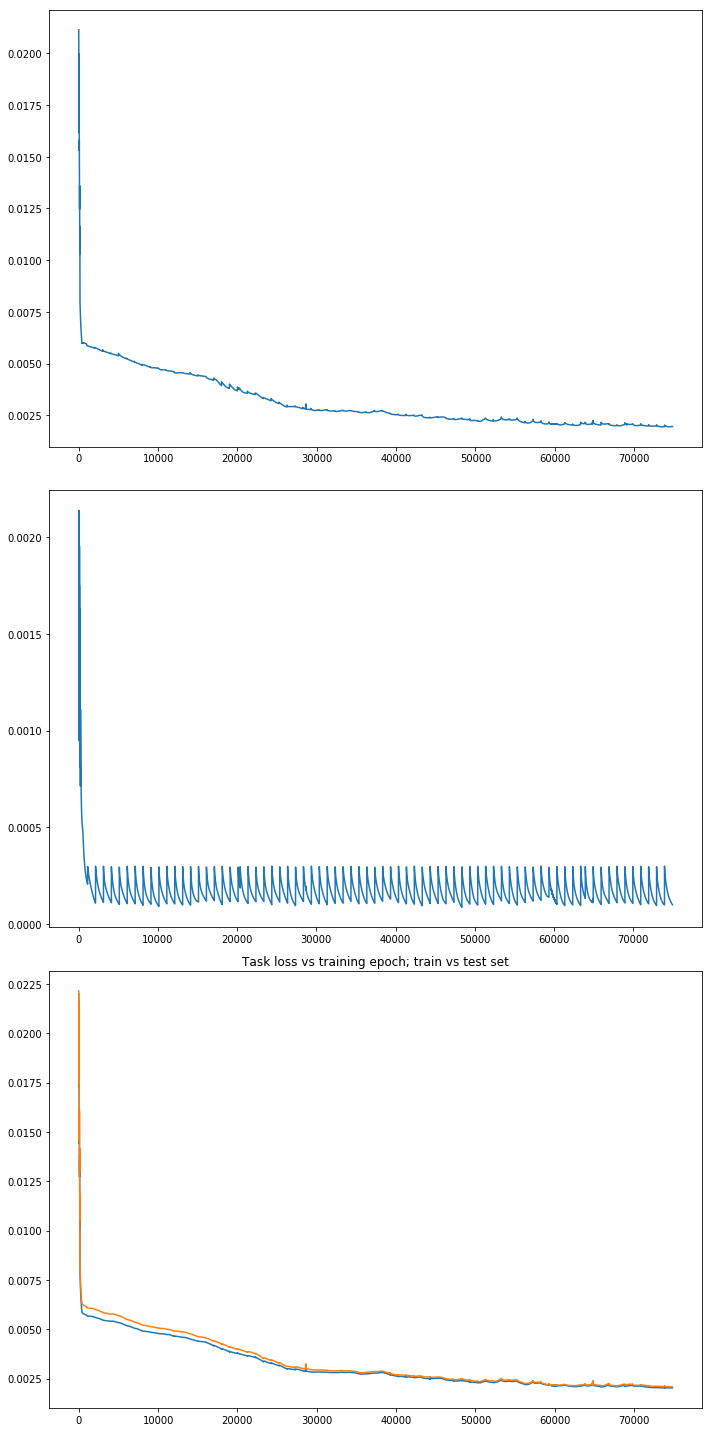

0.9273635984190938 tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [17]:
fig,axs = plt.subplots(3,1, figsize=(10,20))

axs[0].plot(cpn_losses)
print(min(cpn_losses))

axs[1].plot(pred_losses)
print(min(pred_losses))

axs[2].plot(real_losses)
axs[2].plot(test_losses)
axs[2].set_title("Task loss vs training epoch; train vs test set")
print("train:", min(real_losses), "test:", min(test_losses))
fig.tight_layout()
plt.show()

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

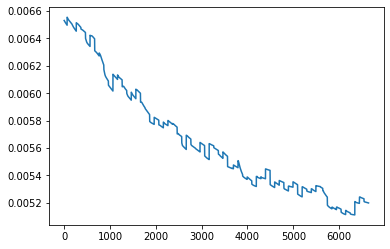

0.005112622398883104


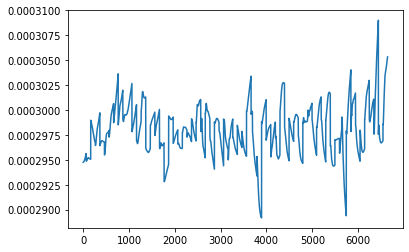

0.00023619270359631628


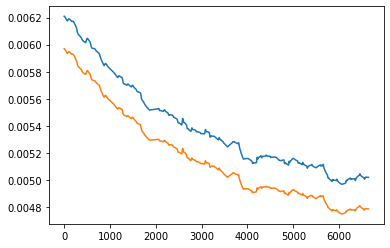

train: 0.004968496970832348 test: 0.004749489016830921
0.7816155845283448 tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [15]:
plt.plot(cpn_losses[1500:])
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses[1500:])
plt.show()
print(min(pred_losses))

plt.plot(real_losses[1500:])
plt.plot(test_losses[1500:])
plt.show()
print("train:", min(real_losses), "test:", min(test_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


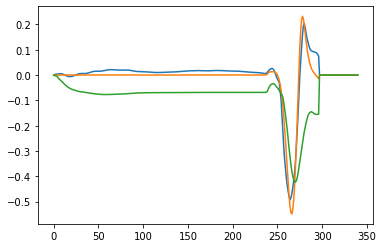

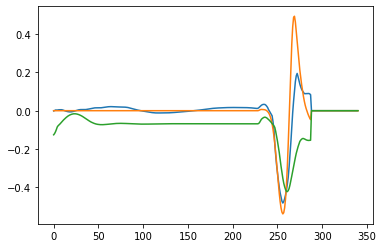

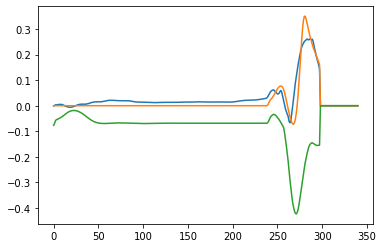

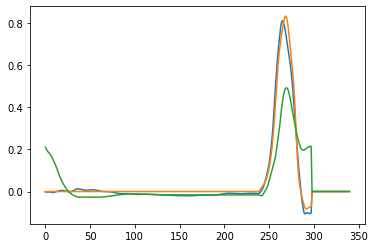

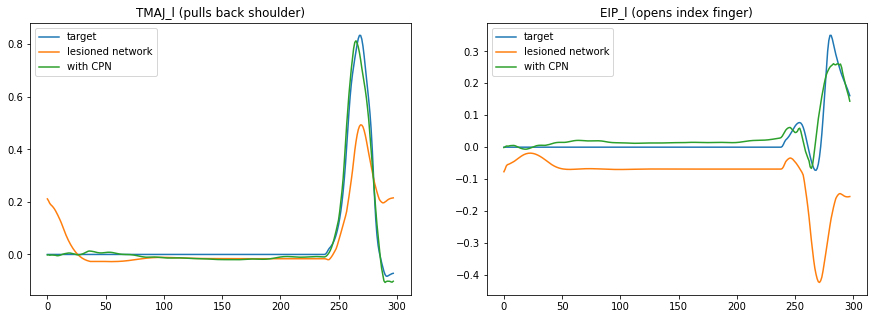

In [89]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T, cuda=CUDA)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T, cuda=CUDA)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T, cuda=CUDA)
mike.reset()

reference_pred_lesioned_0 = utils.trunc_to_trial_end(reference_pred_lesioned_0, trial_end[0, :])
reference_pred_lesioned_neg1 = utils.trunc_to_trial_end(reference_pred_lesioned_neg1, trial_end[-1, :])
reference_pred_lesioned_20 = utils.trunc_to_trial_end(reference_pred_lesioned_20, trial_end[20, :])


print(reference_pred_lesioned_0.shape)


#plt.plot(preds[0, :, 45].cpu().detach().numpy())
#plt.plot(preds.grad[0, :, 45].cpu().detach().numpy())
plt.plot(actuals[0, :, 45].cpu().detach().numpy())
plt.plot(dout[0, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].cpu().detach().numpy())
plt.plot(actuals[-1, :, 45].cpu().detach().numpy())
plt.plot(dout[-1, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_neg1[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].cpu().detach().numpy())
plt.plot(actuals[20, :, 45].cpu().detach().numpy())
plt.plot(dout[20, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].cpu().detach().numpy())
plt.plot(actuals[20, :, 7].cpu().detach().numpy())
plt.plot(dout[20, :, 7].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].cpu().detach().numpy())
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(dout[20, :trial_len[20], 7].cpu().detach().numpy(), label="target")
ax[0].plot(reference_pred_lesioned_20[0, :trial_len[20], 7].cpu().detach().numpy(), label="lesioned network")
ax[0].plot(actuals[20, :trial_len[20], 7].cpu().detach().numpy(), label="with CPN")
ax[0].legend(loc="upper left")
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(dout[20, :trial_len[20], 45].cpu().detach().numpy(), label="target")
ax[1].plot(reference_pred_lesioned_20[0, :trial_len[20], 45].cpu().detach().numpy(), label="lesioned network")
ax[1].plot(actuals[20, :trial_len[20], 45].cpu().detach().numpy(), label="with CPN")
ax[1].legend(loc="upper left")

plt.show()

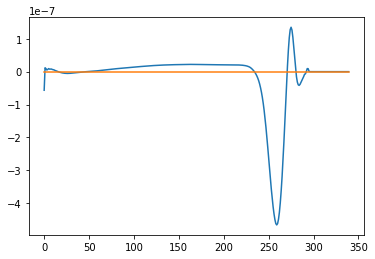

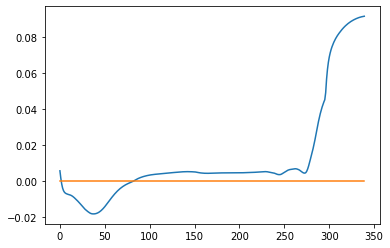

IndexError: index 20 is out of bounds for dimension 1 with size 16

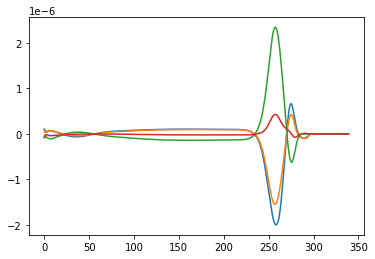

In [16]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

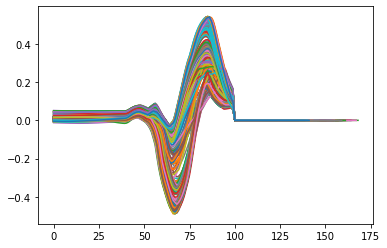

In [63]:
# Are gestures taken between classes?
stout = []
bsize = actuals.shape[0]

for bidx in range(bsize):
    stout.append(actuals[bidx, (trial_len[bidx].item()-100):, 45].cpu().detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()

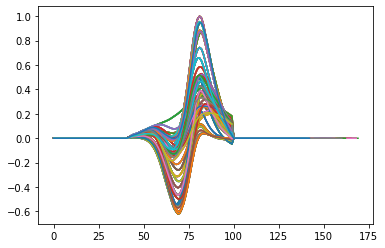

In [64]:
# How does that compare to targets?
stout = []
bsize = dout.shape[0]
for bidx in range(bsize):
    stout.append(dout[bidx, (trial_len[bidx].item()-100):, 45].cpu().detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()